# 95845-A Applied Analytics: The Machine Learning Pipeline

## Final Project: Shawn Leahy and Kaung Khin

## Predicting Influenza Infection with Demographic, Medical, and Search Engine Data

### Data Preparation, Cleaning, Exploration, and Initial Model Building Notebook

### April 30th, 2018

## Demographic Data

We begin by loading the 2015 Household component MEPS data and investigating features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

full_2015 = pd.read_table('full_2015.csv', delimiter=';')
full_2015.shape

C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (518,1057) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(35427, 1832)

In [2]:
#Look at all columns
# print(full_2015.shape)
# print()
# for col in full_2015.columns:
#     print(col)

In [3]:
#subsample columns by using data dictionary (https://meps.ahrq.gov/data_stats/download_data/pufs/h181/h181doc.pdf)
demo_list = ['DUPERSID','REGION15','AGE15X','SEX','RACEV1X','HISPANX',
            'AFDC15','FOODMN15','FAMINC15','POVLEV15','SSECP15X','MNHLTH53','HIBPDX','CHECK53',
            'CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON53','CHOLDX','CANCERDX','DIABDX','ARTHDX','ASTHDX',
            'PREGNT53','FLUSHT53','BMINDX53','TMTKUS42','NOHINS42','HELD53X','SICPAY53','UNINS15','INSURC15','NOINSTM',
            'ERTOT15','OBTOTV15']
full_2015 = full_2015[demo_list]
print(full_2015.shape)


(35427, 38)


In [4]:
#Turn categorical values into dummies
full_2015_dummies = pd.get_dummies(full_2015, columns=['REGION15','RACEV1X','AFDC15','MNHLTH53','HIBPDX','CHDDX',
                                                       'ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON53','CHOLDX',
                                                       'CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53',
                                                       'TMTKUS42','NOHINS42','HELD53X','SICPAY53','INSURC15'])

In [5]:
#drop columns with reserved codes and drop columns to avoid multicollinearity with dummy variables
full_2015_dummies = full_2015_dummies.loc[:, ~full_2015_dummies.columns.str.endswith('-1')]
full_2015_dummies = full_2015_dummies.loc[:, ~full_2015_dummies.columns.str.endswith('-2')]
full_2015_dummies = full_2015_dummies.loc[:, ~full_2015_dummies.columns.str.endswith('-9')]
full_2015_dummies = full_2015_dummies.loc[:, ~full_2015_dummies.columns.str.endswith('-8')]
full_2015_dummies = full_2015_dummies.loc[:, ~full_2015_dummies.columns.str.endswith('-7')]

full_2015_dummies = full_2015_dummies.drop(columns=['CHBRON53_2','CHOLDX_2','CANCERDX_2','DIABDX_2','ARTHDX_2','ASTHDX_2',
                                                   'PREGNT53_2','NOHINS42_2','HELD53X_2','SICPAY53_2','ANGIDX_2'])

In [6]:
#replace -1 reserved code with 0 per documentation
full_2015_dummies.FOODMN15 = full_2015_dummies.FOODMN15.replace(-1,0)
full_2015_dummies.CHECK53 = full_2015_dummies.CHECK53.replace(-1,0)
full_2015_dummies.FLUSHT53 = full_2015_dummies.FLUSHT53.replace(-1,0)
full_2015_dummies.NOINSTM = full_2015_dummies.NOINSTM.replace(-1,0)

replace = full_2015[['POVLEV15','BMINDX53']]
replace = replace.stack().str.replace(',','.').unstack()
full_2015_dummies = full_2015_dummies.drop(columns=['POVLEV15','BMINDX53'])
full_2015_dummies['POVLEV15'] = replace['POVLEV15']
full_2015_dummies['BMINDX53'] = replace['BMINDX53']

#full_2015_dummies.head(20)

### Explore the Data - Check out some histograms of the data

uncomment to see plots

In [7]:
#full_2015.REGION15.hist()

In [8]:
#full_2015.SEX.hist()

In [9]:
#full_2015.RACEV1X.hist()

In [10]:
#full_2015.FAMINC15.hist(bins=20)

In [11]:
#full_2015.UNINS15.value_counts()

In [12]:
#full_2015.ERTOT15.hist()

In [13]:
#full_2015.OBTOTV15.hist()

In [14]:
#full_2015.FLUSHT53.hist()

In [15]:
#full_2015.INSURC15.hist()

## 2015 Medical Conditions file loading and exploration

In [16]:
medical_conditions_2015 = pd.read_table('medical_conditions_2015.csv', delimiter=';')
#medical_conditions_2015.head()

In [17]:
#check columns
# print(medical_conditions_2015.shape)
# print()
# for col in medical_conditions_2015.columns:
#     print(col)

In [18]:
#subset columns based on documentation (https://meps.ahrq.gov/data_stats/download_data/pufs/h180/h180doc.pdf)
medical_conditions_2015 = medical_conditions_2015.drop(columns=['PANEL','CONDRN','AGEDIAG','ACCDNWRK','CRND1','CRND2',
                                                                'CRND3','CRND4','CRND5','PERWT15F','INJURY',
                                                               'VARSTR','VARPSU','DUID','PID','CONDIDX','Unnamed: 0'])
#medical_conditions_2015.head()

In [19]:
#check unique individuals in file
len(medical_conditions_2015.DUPERSID.unique())

26621

In [20]:
#create flag for flu occurence for each person per documentation (CCODEX 123)
medical_conditions_2015['flu_flag'] = np.where(medical_conditions_2015.CCCODEX==123,1,0)

In [21]:
#Check counts of flu/no flu
medical_conditions_2015.flu_flag.value_counts()

0    121515
1      1712
Name: flu_flag, dtype: int64

In [22]:
#Get unique IDs for where flu flag = 1 and drop columns we don't need
flu_DUPERSID = medical_conditions_2015.DUPERSID[medical_conditions_2015['flu_flag']==1]
medical_conditions_2015_grouped = medical_conditions_2015.drop(columns=['CONDN','ICD9CODX','ICD9PROX','CCCODEX','flu_flag'])
#group file by unique ID and get counts of remaining variables (inpatient stays, outpatient stays etc.)
medical_conditions_2015_grouped  = medical_conditions_2015_grouped.groupby(['DUPERSID']).sum()
#medical_conditions_2015_grouped.head()

## Prescription Drugs file loading and exploration

In [23]:
prescription_drugs_2015 = pd.read_table('prescription_drugs_2015.csv', delimiter=';')
#prescription_drugs_2015.head()

C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
#Check columns (https://meps.ahrq.gov/data_stats/download_data/pufs/h178a/h178adoc.pdf)
print(prescription_drugs_2015.shape)
#print()
#for col in prescription_drugs_2015.columns:
#    print(col)

(330453, 70)


In [25]:
#drop columns we do not need
prescription_drugs_2015 = prescription_drugs_2015.drop(columns=['Unnamed: 0','DUID','PID','DRUGIDX','LINKIDX','PANEL',
                                                               'PURCHRD','RXBEGYRX','RXDRGNAM','RXQUANTY',
                                                                'RXFORM','RXFRMUNT','RXSTRENG','RXSTRUNT','RXDAYSUP',
                                                               'OMTYPE','PHARTP1','PHARTP2','PHARTP3','PHARTP4','PHARTP5',
                                                               'PHARTP6','PHARTP7','PHARTP8','RXFLG','IMPFLAG','PCIMPFLG',
                                                               'INPCFLG','SAMPLE','PREGCAT','TC1','TC1S1','TC1S1_1',
                                                               'TC1S1_2','TC1S2','TC1S2_1','TC1S3','TC1S3_1','TC2','TC2S1',
                                                                'TC2S1_1','TC2S1_2','TC2S2','TC3','TC3S1','TC3S1_1',
                                                                'PERWT15F','VARSTR','VARPSU','RXSF15X','RXMR15X',
                                                                'RXMD15X','RXPV15X','RXVA15X','RXTR15X','RXOF15X',
                                                                'RXSL15X','RXWC15X','RXOT15X','RXOR15X','RXOU15X',
                                                                'RXXP15X'])

In [26]:
#get unique individuals in file
len(prescription_drugs_2015.DUPERSID.unique())

19604

In [27]:
#create flag for Tamiflu 
prescription_drugs_2015['Tamiflu_flag'] = np.where(prescription_drugs_2015.RXNAME=='TAMIFLU',1,0)

In [28]:
#counts of Tamiflu 
prescription_drugs_2015.Tamiflu_flag.value_counts()

0    330259
1       194
Name: Tamiflu_flag, dtype: int64

In [29]:
#get unique IDs for where Tamiflu occurs
TAMIFLU_DUPERSID = prescription_drugs_2015.DUPERSID[prescription_drugs_2015['Tamiflu_flag']==1]

## Table Joining - all 2015 files

In [30]:
#household file and medical conditions joining
join1 = full_2015_dummies.join(medical_conditions_2015_grouped,on='DUPERSID')
join1 = join1.fillna(0)

In [31]:
#flu and Tamiflu flags
join1['flu_flag'] = np.where(join1.DUPERSID.isin(flu_DUPERSID),1,0)
join1['tamiflu_flag'] = np.where(join1.DUPERSID.isin(TAMIFLU_DUPERSID),1,0)

In [32]:
#join1[(join1['flu_flag']==0) & (join1['tamiflu_flag']==1)].shape

In [33]:
#join1[(join1['flu_flag']==1) & (join1['tamiflu_flag']==0)].shape

In [34]:
#join1[(join1['flu_flag']==1) & (join1['tamiflu_flag']==1)].shape

In [35]:
#create year flag
join1['Year'] = 2015

## Initial Model Building - just a check w/ single year of data

split data into training and testing w/ flu flag as labels.  Use Random Forest model for prediction

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y = join1.flu_flag
X = join1.drop(columns=['flu_flag','DUPERSID'])
rf = RandomForestClassifier(n_estimators=100,criterion='entropy',n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42,stratify=y)

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
prediction = rf.predict(X_test)
print('Test Accuracy Rate: ',round(accuracy_score(y_test, prediction),3))

Test Accuracy Rate:  0.955


In [39]:
confusion_matrix(y_test, prediction)

array([[16853,    13],
       [  780,    68]], dtype=int64)

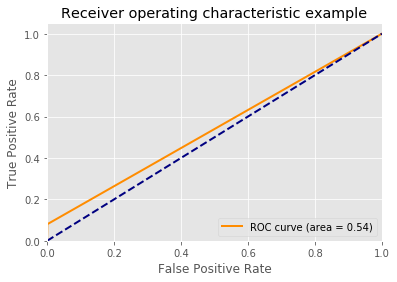

In [40]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Skewed data - no surprise here.  Will have to account for this.

## Other years of data

Replicate process from above done on 2015 for 2012-2014.  

In [41]:
full_2014 = pd.read_table('full_2014.csv', delimiter=';')
medical_conditions_2014 = pd.read_table('medical_conditions_2014.csv', delimiter=';')
prescription_drugs_2014 = pd.read_table('prescription_drugs_2014.csv', delimiter=';')

full_2013 = pd.read_table('full_2013.csv', delimiter=';')
medical_conditions_2013 = pd.read_table('medical_conditions_2013.csv', delimiter=';')
prescription_drugs_2013 = pd.read_table('prescription_drugs_2013.csv', delimiter=';')

full_2012 = pd.read_table('full_2012.csv', delimiter=';')
medical_conditions_2012 = pd.read_table('medical_conditions_2012.csv', delimiter=';')
prescription_drugs_2012 = pd.read_table('prescription_drugs_2012.csv', delimiter=';')

C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (515,525,1064) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (60,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (551,1021) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\spleahy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=

### Exploration on all years of data

Text(0.5,1,'Histogram of Sample Population by Region for 2012-2015')

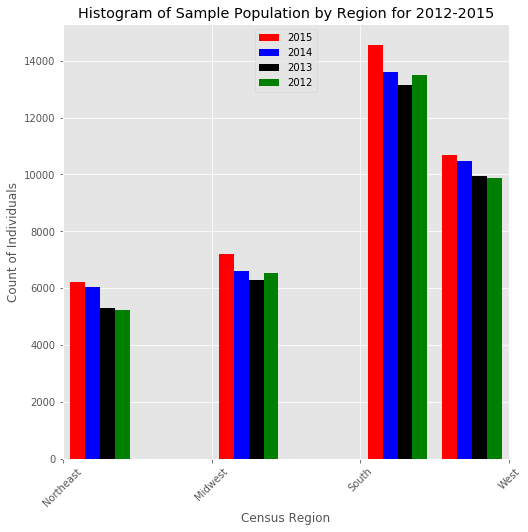

In [42]:
labels = ['2015', '2014', '2013', '2012']
plt.figure(figsize=(8,8))

plt.hist(np.array(pd.DataFrame({'2015':full_2015.REGION15,
                                '2014':full_2014.REGION14,
                                '2013':full_2013.REGION13,
                                '2012':full_2012.REGION12})),
         density=False, histtype='bar', color=['red','blue','black','green'], label=labels)

plt.legend(labels, loc='upper center')
plt.xticks(range(-1,5),['None','','Northeast','Midwest','South','West'], rotation=45)
plt.xlim(1,4)
plt.ylabel('Count of Individuals')
plt.xlabel('Census Region')
plt.title('Histogram of Sample Population by Region for 2012-2015')

Text(0.5,1,'Histogram of Sample Population by Race for 2012-2015')

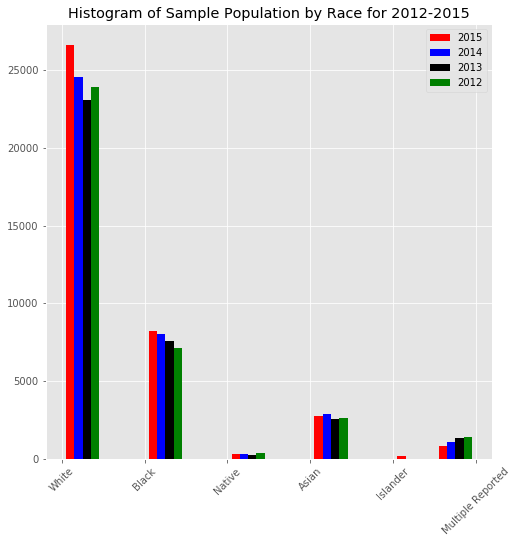

In [43]:
plt.figure(figsize=(8,8))
plt.hist(np.array(pd.DataFrame({'2015':full_2015.RACEV1X,
                                '2014':full_2014.RACEV1X,
                                '2013':full_2013.RACEV1X,
                                '2012':full_2012.RACEV1X})),
         density=False, histtype='bar', color=['red','blue','black','green'], label=labels)

plt.legend(labels)
plt.xticks(range(1,7),['White','Black','Native','Asian','Islander','Multiple Reported'], rotation=45)
plt.title('Histogram of Sample Population by Race for 2012-2015')


Text(0.5,1,'Histogram of Sample Population by Family Income for 2012-2015')

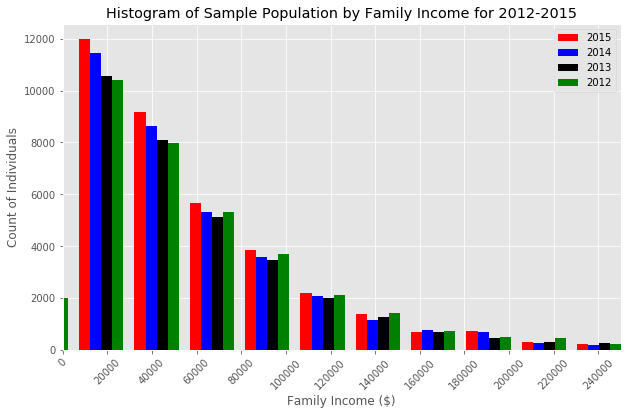

In [46]:
plt.figure(figsize=(10,6))
plt.hist(np.array(pd.DataFrame({'2015':full_2015.FAMINC15,
                                '2014':full_2014.FAMINC14,
                                '2013':full_2013.FAMINC13,
                                '2012':full_2012.FAMINC12})),
         density=False, histtype='bar', color=['red','blue','black','green'], label=labels, bins=20)
plt.xticks(np.arange(0, 250000, step=20000),rotation=45)
plt.xlim(0,250000)
plt.ylabel('Count of Individuals')
plt.xlabel('Family Income ($)')
plt.legend(labels)
plt.title('Histogram of Sample Population by Family Income for 2012-2015')

Text(0.5,1,'Histogram of Sample Population by Number of Weeks Without Health Insurance for 2012-2015')

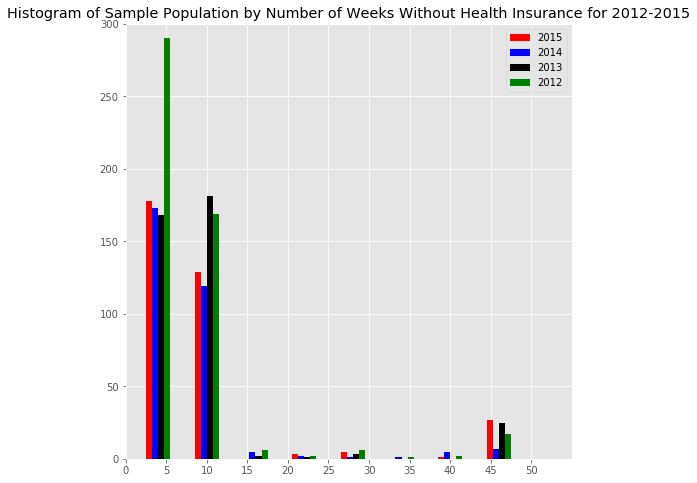

In [47]:
plt.figure(figsize=(8,8))
plt.hist(np.array(pd.DataFrame({'2015':full_2015.NOINSTM,
                                '2014':full_2014.NOINSTM,
                                '2013':full_2013.NOINSTM,
                                '2012':full_2012.NOINSTM})),
         density=False, histtype='bar', color=['red','blue','black','green'], 
         label=labels, rwidth=0.5, bins=10, align='left')

plt.legend(labels)
plt.xticks(range(0,55,5))
plt.xlim(0,55)
plt.ylim(0,300)
plt.title('Histogram of Sample Population by Number of Weeks Without Health Insurance for 2012-2015')

([<matplotlib.axis.XTick at 0x1a6da25cd30>,
 <a list of 28 Text xticklabel objects>)

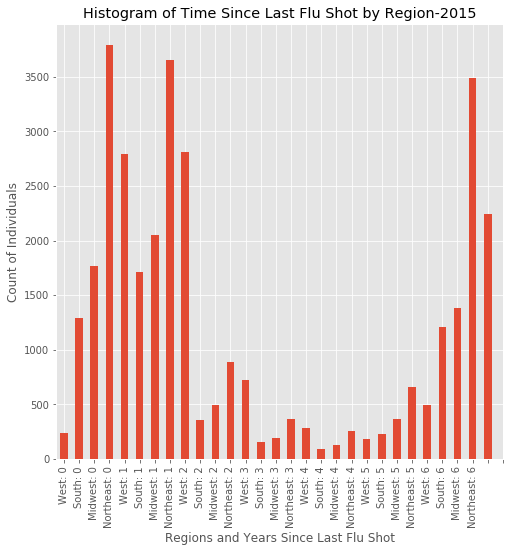

In [48]:
plt.figure(figsize=(10,10))

full_2015[['REGION15',
           'FLUSHT53',
           'DUPERSID']][full_2015['FLUSHT53'] >= -1].groupby(['FLUSHT53',
                                                              'REGION15']).agg('count').plot(kind='bar',
                                                                                                    figsize=(8,8),
                                                                                                    legend=False,
                                                                                                    title='Histogram of Time Since Last Flu Shot by Region-2015')
plt.xlabel('Regions and Years Since Last Flu Shot')
plt.ylabel('Count of Individuals')
plt.xticks(range(0,30),['West: 0','South: 0','Midwest: 0','Northeast: 0',
           'West: 1','South: 1','Midwest: 1','Northeast: 1',
           'West: 2','South: 2','Midwest: 2','Northeast: 2',
           'West: 3','South: 3','Midwest: 3','Northeast: 3',
           'West: 4','South: 4','Midwest: 4','Northeast: 4',
           'West: 5','South: 5','Midwest: 5','Northeast: 5',
            'West: 6','South: 6','Midwest: 6','Northeast: 6'])

### Cleaning for other years of data

In [49]:
#2014 cleaning
demo_list_2014 = ['DUPERSID','REGION14','AGE14X','SEX','RACEV1X','HISPANX','AFDC14','FOODMN14','FAMINC14',
                  'POVLEV14','SSECP14X','MNHLTH53','HIBPDX','CHECK53','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
                  'CHBRON53','CHOLDX','CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53','FLUSHT53','BMINDX53','TMTKUS42',
                  'NOHINS42','HELD53X','SICPAY53','UNINS14','INSURC14','NOINSTM','ERTOT14','OBTOTV14']
full_2014 = full_2014[demo_list_2014]
full_2014_dummies = pd.get_dummies(full_2014, columns=['REGION14','RACEV1X','AFDC14','MNHLTH53','HIBPDX','CHDDX',
                                                       'ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON53','CHOLDX',
                                                       'CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53',
                                                       'TMTKUS42','NOHINS42','HELD53X','SICPAY53','INSURC14'])
full_2014_dummies = full_2014_dummies.loc[:, ~full_2014_dummies.columns.str.endswith('-1')]
full_2014_dummies = full_2014_dummies.loc[:, ~full_2014_dummies.columns.str.endswith('-2')]
full_2014_dummies = full_2014_dummies.loc[:, ~full_2014_dummies.columns.str.endswith('-9')]
full_2014_dummies = full_2014_dummies.loc[:, ~full_2014_dummies.columns.str.endswith('-8')]
full_2014_dummies = full_2014_dummies.loc[:, ~full_2014_dummies.columns.str.endswith('-7')]

full_2014_dummies = full_2014_dummies.drop(columns=['CHBRON53_2','CHOLDX_2','CANCERDX_2','DIABDX_2','ARTHDX_2','ASTHDX_2',
                                                   'PREGNT53_2','NOHINS42_2','HELD53X_2','SICPAY53_2','ANGIDX_2'])

full_2014_dummies.FOODMN14 = full_2014_dummies.FOODMN14.replace(-1,0)
full_2014_dummies.CHECK53 = full_2014_dummies.CHECK53.replace(-1,0)
full_2014_dummies.FLUSHT53 = full_2014_dummies.FLUSHT53.replace(-1,0)
full_2014_dummies.NOINSTM = full_2014_dummies.NOINSTM.replace(-1,0)

replace = full_2014[['POVLEV14','BMINDX53']]
replace = replace.stack().str.replace(',','.').unstack()
full_2014_dummies = full_2014_dummies.drop(columns=['POVLEV14','BMINDX53'])
full_2014_dummies['POVLEV14'] = replace['POVLEV14']
full_2014_dummies['BMINDX53'] = replace['BMINDX53']

In [50]:
medical_conditions_2014 = medical_conditions_2014.drop(columns=['PANEL','CONDRN','AGEDIAG','ACCDNWRK','CRND1','CRND2',
                                                                'CRND3','CRND4','CRND5','PERWT14F','INJURY',
                                                               'VARSTR','VARPSU','DUID','PID','CONDIDX','Unnamed: 0'])
medical_conditions_2014['flu_flag'] = np.where(medical_conditions_2014.CCCODEX==123,1,0)
flu_DUPERSID_2014 = medical_conditions_2014.DUPERSID[medical_conditions_2014['flu_flag']==1]
medical_conditions_2014_grouped = medical_conditions_2014.drop(columns=['CONDN','ICD9CODX','ICD9PROX','CCCODEX','flu_flag'])
medical_conditions_2014_grouped  = medical_conditions_2014_grouped.groupby(['DUPERSID']).sum()


In [51]:
prescription_drugs_2014 = prescription_drugs_2014.drop(columns=['Unnamed: 0','DUID','PID','DRUGIDX','LINKIDX','PANEL',
                                                               'PURCHRD','RXBEGYRX','RXDRGNAM','RXQUANTY',
                                                                'RXFORM','RXFRMUNT','RXSTRENG','RXSTRUNT','RXDAYSUP',
                                                               'OMTYPE','PHARTP1','PHARTP2','PHARTP3','PHARTP4','PHARTP5',
                                                               'PHARTP6','PHARTP7','PHARTP8','RXFLG','IMPFLAG','PCIMPFLG',
                                                               'INPCFLG','SAMPLE','PREGCAT','TC1','TC1S1','TC1S1_1',
                                                               'TC1S1_2','TC1S2','TC1S2_1','TC1S3','TC1S3_1','TC2','TC2S1',
                                                                'TC2S1_1','TC2S1_2','TC2S2','TC3','TC3S1','TC3S1_1',
                                                                'PERWT14F','VARSTR','VARPSU','RXSF14X','RXMR14X',
                                                                'RXMD14X','RXPV14X','RXVA14X','RXTR14X','RXOF14X',
                                                                'RXSL14X','RXWC14X','RXOT14X','RXOR14X','RXOU14X',
                                                                'RXXP14X'])
prescription_drugs_2014['Tamiflu_flag'] = np.where(prescription_drugs_2014.RXNAME=='TAMIFLU',1,0)
TAMIFLU_DUPERSID_2014 = prescription_drugs_2014.DUPERSID[prescription_drugs_2014['Tamiflu_flag']==1]

In [52]:
#2013 cleaning
demo_list_2013 = ['DUPERSID','REGION13','AGE13X','SEX','RACEV1X','HISPANX','AFDC13','FOODMN13','FAMINC13',
                  'POVLEV13','SSECP13X','MNHLTH53','HIBPDX','CHECK53','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
                  'CHBRON53','CHOLDX','CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53','FLUSHT53','BMINDX53','TMTKUS42',
                  'NOHINS42','HELD53X','SICPAY53','UNINS13','INSURC13','NOINSTM','ERTOT13','OBTOTV13']
full_2013 = full_2013[demo_list_2013]
full_2013_dummies = pd.get_dummies(full_2013, columns=['REGION13','RACEV1X','AFDC13','MNHLTH53','HIBPDX','CHDDX',
                                                       'ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON53','CHOLDX',
                                                       'CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53',
                                                       'TMTKUS42','NOHINS42','HELD53X','SICPAY53','INSURC13'])
full_2013_dummies = full_2013_dummies.loc[:, ~full_2013_dummies.columns.str.endswith('-1')]
full_2013_dummies = full_2013_dummies.loc[:, ~full_2013_dummies.columns.str.endswith('-2')]
full_2013_dummies = full_2013_dummies.loc[:, ~full_2013_dummies.columns.str.endswith('-9')]
full_2013_dummies = full_2013_dummies.loc[:, ~full_2013_dummies.columns.str.endswith('-8')]
full_2013_dummies = full_2013_dummies.loc[:, ~full_2013_dummies.columns.str.endswith('-7')]

full_2013_dummies = full_2013_dummies.drop(columns=['CHBRON53_2','CHOLDX_2','CANCERDX_2','DIABDX_2','ARTHDX_2','ASTHDX_2',
                                                   'PREGNT53_2','NOHINS42_2','HELD53X_2','SICPAY53_2','ANGIDX_2'])

full_2013_dummies.FOODMN13 = full_2013_dummies.FOODMN13.replace(-1,0)
full_2013_dummies.CHECK53 = full_2013_dummies.CHECK53.replace(-1,0)
full_2013_dummies.FLUSHT53 = full_2013_dummies.FLUSHT53.replace(-1,0)
full_2013_dummies.NOINSTM = full_2013_dummies.NOINSTM.replace(-1,0)

replace = full_2013[['POVLEV13','BMINDX53']]
replace = replace.stack().str.replace(',','.').unstack()
full_2013_dummies = full_2013_dummies.drop(columns=['POVLEV13','BMINDX53'])
full_2013_dummies['POVLEV13'] = replace['POVLEV13']
full_2013_dummies['BMINDX53'] = replace['BMINDX53']

In [53]:
medical_conditions_2013 = medical_conditions_2013.drop(columns=['PANEL','CONDRN','AGEDIAG','ACCDNWRK','CRND1','CRND2',
                                                                'CRND3','CRND4','CRND5','PERWT13F','INJURY',
                                                               'VARSTR','VARPSU','DUID','PID','CONDIDX','Unnamed: 0'])
medical_conditions_2013['flu_flag'] = np.where(medical_conditions_2013.CCCODEX==123,1,0)
flu_DUPERSID_2013 = medical_conditions_2013.DUPERSID[medical_conditions_2013['flu_flag']==1]
medical_conditions_2013_grouped = medical_conditions_2013.drop(columns=['CONDN','ICD9CODX','ICD9PROX','CCCODEX','flu_flag'])
medical_conditions_2013_grouped  = medical_conditions_2013_grouped.groupby(['DUPERSID']).sum()

In [54]:
prescription_drugs_2013 = prescription_drugs_2013.drop(columns=['Unnamed: 0','DUID','PID','DRUGIDX','LINKIDX','PANEL',
                                                               'PURCHRD','RXBEGYRX','RXDRGNAM','RXQUANTY',
                                                                'RXFORM','RXFRMUNT','RXSTRENG','RXSTRUNT','RXDAYSUP',
                                                                'PHARTP1','PHARTP2','PHARTP3','PHARTP4','PHARTP5',
                                                               'PHARTP6','PHARTP7','PHARTP8','RXFLG','IMPFLAG','PCIMPFLG',
                                                               'INPCFLG','SAMPLE','PREGCAT','TC1','TC1S1','TC1S1_1',
                                                               'TC1S1_2','TC1S2','TC1S2_1','TC1S3','TC1S3_1','TC2','TC2S1',
                                                                'TC2S1_1','TC2S1_2','TC2S2','TC3','TC3S1','TC3S1_1',
                                                                'PERWT13F','VARSTR','VARPSU','RXSF13X','RXMR13X',
                                                                'RXMD13X','RXPV13X','RXVA13X','RXTR13X','RXOF13X',
                                                                'RXSL13X','RXWC13X','RXOT13X','RXOR13X','RXOU13X',
                                                                'RXXP13X','CLMOMFLG'])
prescription_drugs_2013['Tamiflu_flag'] = np.where(prescription_drugs_2013.RXNAME=='TAMIFLU',1,0)
TAMIFLU_DUPERSID_2013 = prescription_drugs_2013.DUPERSID[prescription_drugs_2013['Tamiflu_flag']==1]

In [55]:
#2012 cleaning
demo_list_2012 = ['DUPERSID','REGION12','AGE12X','SEX','RACEV1X','HISPANX','AFDC12','FOODMN12','FAMINC12',
                  'POVLEV12','SSECP12X','MNHLTH53','HIBPDX','CHECK53','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
                  'CHBRON53','CHOLDX','CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53','FLUSHT53','BMINDX53','TMTKUS42',
                  'NOHINS42','HELD53X','SICPAY53','UNINS12','INSURC12','NOINSTM','ERTOT12','OBTOTV12']
full_2012 = full_2012[demo_list_2012]
full_2012_dummies = pd.get_dummies(full_2012, columns=['REGION12','RACEV1X','AFDC12','MNHLTH53','HIBPDX','CHDDX',
                                                       'ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON53','CHOLDX',
                                                       'CANCERDX','DIABDX','ARTHDX','ASTHDX','PREGNT53',
                                                       'TMTKUS42','NOHINS42','HELD53X','SICPAY53','INSURC12'])
full_2012_dummies = full_2012_dummies.loc[:, ~full_2012_dummies.columns.str.endswith('-1')]
full_2012_dummies = full_2012_dummies.loc[:, ~full_2012_dummies.columns.str.endswith('-2')]
full_2012_dummies = full_2012_dummies.loc[:, ~full_2012_dummies.columns.str.endswith('-9')]
full_2012_dummies = full_2012_dummies.loc[:, ~full_2012_dummies.columns.str.endswith('-8')]
full_2012_dummies = full_2012_dummies.loc[:, ~full_2012_dummies.columns.str.endswith('-7')]

full_2012_dummies = full_2012_dummies.drop(columns=['CHBRON53_2','CHOLDX_2','CANCERDX_2','DIABDX_2','ARTHDX_2','ASTHDX_2',
                                                   'PREGNT53_2','NOHINS42_2','HELD53X_2','SICPAY53_2','RACEV1X_5','ANGIDX_2'])

full_2012_dummies.FOODMN12 = full_2012_dummies.FOODMN12.replace(-1,0)
full_2012_dummies.CHECK53 = full_2012_dummies.CHECK53.replace(-1,0)
full_2012_dummies.FLUSHT53 = full_2012_dummies.FLUSHT53.replace(-1,0)
full_2012_dummies.NOINSTM = full_2012_dummies.NOINSTM.replace(-1,0)

replace = full_2012[['POVLEV12','BMINDX53']]
replace = replace.stack().str.replace(',','.').unstack()
full_2012_dummies = full_2012_dummies.drop(columns=['POVLEV12','BMINDX53'])
full_2012_dummies['POVLEV12'] = replace['POVLEV12']
full_2012_dummies['BMINDX53'] = replace['BMINDX53']

In [56]:
medical_conditions_2012 = medical_conditions_2012.drop(columns=['PANEL','CONDRN','AGEDIAG','ACCDNWRK','CRND1','CRND2',
                                                                'CRND3','CRND4','CRND5','PERWT12F','INJURY',
                                                               'VARSTR','VARPSU','DUID','PID','CONDIDX','Unnamed: 0'])
medical_conditions_2012['flu_flag'] = np.where(medical_conditions_2012.CCCODEX==123,1,0)
flu_DUPERSID_2012 = medical_conditions_2012.DUPERSID[medical_conditions_2012['flu_flag']==1]
medical_conditions_2012_grouped = medical_conditions_2012.drop(columns=['CONDN','ICD9CODX','ICD9PROX','CCCODEX','flu_flag',
                                                                        'ACCDENTD','ACCDENTM','ACCDENTY','ACCDNJAN',
                                                                        'INBEDFLG','MISSSCHL','MISSWORK','REMISSN'])
medical_conditions_2012_grouped  = medical_conditions_2012_grouped.groupby(['DUPERSID']).sum()

In [57]:
prescription_drugs_2012 = prescription_drugs_2012.drop(columns=['Unnamed: 0','DUID','PID','DRUGIDX','LINKIDX','PANEL',
                                                               'PURCHRD','RXBEGYRX','RXQUANTY',
                                                                'RXFORM','RXFRMUNT','RXSTRENG','RXSTRUNT','RXDAYSUP',
                                                                'PHARTP1','PHARTP2','PHARTP3','PHARTP4','PHARTP5',
                                                               'PHARTP6','PHARTP7','PHARTP8','RXFLG','IMPFLAG','PCIMPFLG',
                                                               'INPCFLG','SAMPLE','PREGCAT','TC1','TC1S1','TC1S1_1',
                                                               'TC1S1_2','TC1S2','TC1S2_1','TC1S3','TC1S3_1','TC2','TC2S1',
                                                                'TC2S1_1','TC2S1_2','TC2S2','TC3','TC3S1','TC3S1_1',
                                                                'PERWT12F','VARSTR','VARPSU','RXSF12X','RXMR12X',
                                                                'RXMD12X','RXPV12X','RXVA12X','RXTR12X','RXOF12X',
                                                                'RXSL12X','RXWC12X','RXOT12X','RXOR12X','RXOU12X',
                                                                'RXXP12X','CLMOMFLG', 'PHARTP10', 'PHARTP9', 'RXBEGDD', 
                                                                'RXICD1X', 'RXICD2X', 'RXICD3X'])
prescription_drugs_2012['Tamiflu_flag'] = np.where(prescription_drugs_2012.RXNAME=='TAMIFLU',1,0)
TAMIFLU_DUPERSID_2012 = prescription_drugs_2012.DUPERSID[prescription_drugs_2012['Tamiflu_flag']==1]

### Year by Year Dataframe Joining

In [58]:
print(full_2015_dummies.shape)
print(full_2014_dummies.shape)
print(full_2013_dummies.shape)
print(full_2012_dummies.shape)

(35427, 68)
(34875, 68)
(36940, 68)
(38974, 68)


In [59]:
print(medical_conditions_2015_grouped.shape)
print(medical_conditions_2014_grouped.shape)
print(medical_conditions_2013_grouped.shape)
print(medical_conditions_2012_grouped.shape)

(26621, 6)
(25870, 6)
(28576, 6)
(29537, 6)


In [60]:
print(prescription_drugs_2015.shape)
print(prescription_drugs_2014.shape)
print(prescription_drugs_2013.shape)
print(prescription_drugs_2012.shape)

(330453, 9)
(319467, 9)
(327557, 9)
(324744, 9)


In [61]:
join2 = full_2014_dummies.join(medical_conditions_2014_grouped,on='DUPERSID')
join2 = join2.fillna(0)

join2['flu_flag'] = np.where(join2.DUPERSID.isin(flu_DUPERSID_2014),1,0)
join2['tamiflu_flag'] = np.where(join2.DUPERSID.isin(TAMIFLU_DUPERSID_2014),1,0)

join2['Year'] = 2014

In [62]:
join3 = full_2013_dummies.join(medical_conditions_2013_grouped,on='DUPERSID')
join3 = join3.fillna(0)

join3['flu_flag'] = np.where(join3.DUPERSID.isin(flu_DUPERSID_2013),1,0)
join3['tamiflu_flag'] = np.where(join3.DUPERSID.isin(TAMIFLU_DUPERSID_2013),1,0)

join3['Year'] = 2013

In [63]:
join4 = full_2012_dummies.join(medical_conditions_2012_grouped,on='DUPERSID')
join4 = join4.fillna(0)

join4['flu_flag'] = np.where(join4.DUPERSID.isin(flu_DUPERSID_2012),1,0)
join4['tamiflu_flag'] = np.where(join4.DUPERSID.isin(TAMIFLU_DUPERSID_2012),1,0)

join4['Year'] = 2012

In [64]:
#Check some counts in all the years
print("2015 No flu but Tamiflu: ",join1[(join1['flu_flag']==0) & (join1['tamiflu_flag']==1)].shape[0])
print("2014 No flu but Tamiflu: ",join2[(join2['flu_flag']==0) & (join2['tamiflu_flag']==1)].shape[0])
print("2013 No flu but Tamiflu: ",join3[(join3['flu_flag']==0) & (join3['tamiflu_flag']==1)].shape[0])
print("2012 No flu but Tamiflu: ",join4[(join4['flu_flag']==0) & (join4['tamiflu_flag']==1)].shape[0])
print()      

print("2015 flu but no Tamiflu: ",join1[(join1['flu_flag']==1) & (join1['tamiflu_flag']==0)].shape[0])
print("2014 flu but no Tamiflu: ",join2[(join2['flu_flag']==1) & (join2['tamiflu_flag']==0)].shape[0])
print("2013 flu but no Tamiflu: ",join3[(join3['flu_flag']==1) & (join3['tamiflu_flag']==0)].shape[0])
print("2012 flu but no Tamiflu: ",join4[(join4['flu_flag']==1) & (join4['tamiflu_flag']==0)].shape[0])
print()
print("2015 flu and Tamiflu: ",join1[(join1['flu_flag']==1) & (join1['tamiflu_flag']==1)].shape[0])
print("2014 flu and Tamiflu: ",join2[(join2['flu_flag']==1) & (join2['tamiflu_flag']==1)].shape[0])
print("2013 flu and Tamiflu: ",join3[(join3['flu_flag']==1) & (join3['tamiflu_flag']==1)].shape[0])
print("2012 flu and Tamiflu: ",join4[(join4['flu_flag']==1) & (join4['tamiflu_flag']==1)].shape[0])

2015 No flu but Tamiflu:  28
2014 No flu but Tamiflu:  38
2013 No flu but Tamiflu:  23
2012 No flu but Tamiflu:  25

2015 flu but no Tamiflu:  1542
2014 flu but no Tamiflu:  1606
2013 flu but no Tamiflu:  3060
2012 flu but no Tamiflu:  3025

2015 flu and Tamiflu:  153
2014 flu and Tamiflu:  197
2013 flu and Tamiflu:  154
2012 flu and Tamiflu:  86


### Rename Columns - to make slicing simpler going forward

In [65]:
cols_to_rename1 = sorted(list(set(join1.columns) - set(join2.columns)))
cols_to_rename2 = sorted(list(set(join2.columns) - set(join1.columns)))
cols_to_rename3 = sorted(list(set(join3.columns) - set(join1.columns)))
cols_to_rename4 = sorted(list(set(join4.columns) - set(join1.columns)))

dict1 = dict(zip(cols_to_rename2, cols_to_rename1))
dict2 = dict(zip(cols_to_rename3, cols_to_rename1))
dict3 = dict(zip(cols_to_rename4, cols_to_rename1))

join2 = join2.rename(index = str, columns=dict1)
join3 = join3.rename(index = str, columns=dict2)
join4 = join4.rename(index = str, columns=dict3)

## Incorporating Google Trends data for each year

Values are calculated on a scale from 0 to 100, where 100 is the location with the most popularity as a fraction of total searches in that location, a value of 50 indicates a location which is half as popular. A value of 0 indicates a location where there was not enough data for this term.

Note: A higher value means a higher proportion of all queries, not a higher absolute query count. So a tiny state where 80% of the queries are for "bananas" will get twice the score of a giant country where only 40% of the queries are for "bananas".

In [66]:
#Lists for states in each Census Region
northeast1 = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'New Jersey','New York', 
             'Pennsylvania', 'Rhode Island', 'Vermont']
midwest2 = ['Indiana', 'Illinois', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri','Nebraska', 'North Dakota', 
            'Ohio', 'South Dakota', 'Wisconsin']
south3 = ['Alabama', 'Arkansas', 'Delaware, District of Columbia', 'Florida','Georgia', 'Kentucky', 'Louisiana', 
          'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 
          'Texas', 'Virginia', 'West Virginia']
west4 = ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 
         'Oregon', 'Utah', 'Washington', 'Wyoming' ]
trends_2012 = pd.read_csv('trends_2012.csv', skiprows=2)
trends_2013 = pd.read_csv('trends_2013.csv', skiprows=2)
trends_2014 = pd.read_csv('trends_2014.csv', skiprows=2)
trends_2015 = pd.read_csv('trends_2015.csv', skiprows=2)

In [67]:
#northeast for all years
northeast_2012 = trends_2012[trends_2012['Region'].isin(northeast1)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2012)'].mean()
northeast_2013 = trends_2013[trends_2013['Region'].isin(northeast1)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2013)'].mean()
northeast_2014 = trends_2014[trends_2014['Region'].isin(northeast1)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2014)'].mean()
northeast_2015 = trends_2015[trends_2015['Region'].isin(northeast1)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2015)'].mean()

northeast = [northeast_2012, northeast_2013, northeast_2014, northeast_2015]

In [68]:
#midwest for all years
midwest_2012 = trends_2012[trends_2012['Region'].isin(midwest2)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2012)'].mean()
midwest_2013 = trends_2013[trends_2013['Region'].isin(midwest2)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2013)'].mean()
midwest_2014 = trends_2014[trends_2014['Region'].isin(midwest2)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2014)'].mean()
midwest_2015 = trends_2015[trends_2015['Region'].isin(midwest2)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2015)'].mean()

midwest = [midwest_2012, midwest_2013, midwest_2014, midwest_2015]

In [69]:
#south for all years
south_2012 = trends_2012[trends_2012['Region'].isin(south3)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2012)'].mean()
south_2013 = trends_2013[trends_2013['Region'].isin(south3)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2013)'].mean()
south_2014 = trends_2014[trends_2014['Region'].isin(south3)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2014)'].mean()
south_2015 = trends_2015[trends_2015['Region'].isin(south3)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2015)'].mean()

south = [south_2012, south_2013,south_2014, south_2015]

In [70]:
#west for all years
west_2012 = trends_2012[trends_2012['Region'].isin(west4)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2012)'].mean()
west_2013 = trends_2013[trends_2013['Region'].isin(west4)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2013)'].mean()
west_2014 = trends_2014[trends_2014['Region'].isin(west4)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2014)'].mean()
west_2015 = trends_2015[trends_2015['Region'].isin(west4)]['influenza + flu + flu symptoms + flu treatments + flu remedies: (2015)'].mean()

west = [west_2012, west_2013, west_2014, west_2015]

In [71]:
#create average percentages for each region for each year
year = [2012,2013,2014,2015]

trend_regions = pd.DataFrame(year, columns=['Year'])
trend_regions['1'] = [x/100 for x in northeast]
trend_regions['2'] = [x/100 for x in midwest]
trend_regions['3'] = [x/100 for x in south]
trend_regions['4'] =[x/100 for x in west]
trend_regions

,Year,1,2,3,4
0,2012,0.652222,0.756667,0.712667,0.645385
1,2013,0.772222,0.820833,0.792667,0.710000
2,2014,0.702222,0.854167,0.800000,0.700000
3,2015,0.508889,0.630000,0.532667,0.503077


In [72]:
#for 2015 create columns that adds the average flu trend search proportion to each row for the appropriate region
flu_region_2015 = pd.Series()
for row in range(join1.shape[0]):
    if join1['REGION15_1'][row]==1:
        flu_region_2015=flu_region_2015.append(trend_regions[3:]['1'], ignore_index=True)
    elif join1['REGION15_2'][row]==1:
        flu_region_2015=flu_region_2015.append(trend_regions[3:]['2'], ignore_index=True)
    elif join1['REGION15_3'][row]==1:
        flu_region_2015=flu_region_2015.append(trend_regions[3:]['3'], ignore_index=True)
    elif join1['REGION15_4'][row]==1:
        flu_region_2015=flu_region_2015.append(trend_regions[3:]['4'], ignore_index=True)
    else:
        flu_region_2015[row]=0
        
join1['flu_region'] = flu_region_2015.values       

In [73]:
#for 2014 create columns that adds the average flu trend search proportion to each row for the appropriate region
flu_region_2014 = pd.Series()
for row in range(join2.shape[0]):
    if join2['REGION15_1'][row]==1:
        flu_region_2014=flu_region_2014.append(trend_regions[2:3]['1'], ignore_index=True)
    elif join2['REGION15_2'][row]==1:
        flu_region_2014=flu_region_2014.append(trend_regions[2:3]['2'], ignore_index=True)
    elif join2['REGION15_3'][row]==1:
        flu_region_2014=flu_region_2014.append(trend_regions[2:3]['3'], ignore_index=True)
    elif join2['REGION15_4'][row]==1:
        flu_region_2014=flu_region_2014.append(trend_regions[2:3]['4'], ignore_index=True)
    else:
        flu_region_2014[row]=0
        
join2['flu_region'] = flu_region_2014.values

In [74]:
#for 2013 create columns that adds the average flu trend search proportion to each row for the appropriate region
flu_region_2013 = pd.Series()
for row in range(join3.shape[0]):
    if join3['REGION15_1'][row]==1:
        flu_region_2013=flu_region_2013.append(trend_regions[1:2]['1'], ignore_index=True)
    elif join3['REGION15_2'][row]==1:
        flu_region_2013=flu_region_2013.append(trend_regions[1:2]['2'], ignore_index=True)
    elif join3['REGION15_3'][row]==1:
        flu_region_2013=flu_region_2013.append(trend_regions[1:2]['3'], ignore_index=True)
    elif join3['REGION15_4'][row]==1:
        flu_region_2013=flu_region_2013.append(trend_regions[1:2]['4'], ignore_index=True)
    else:
        flu_region_2013[row]=0
        
join3['flu_region'] = flu_region_2013.values

In [75]:
#for 2012 create columns that adds the average flu trend search proportion to each row for the appropriate region
flu_region_2012 = pd.Series()
for row in range(join4.shape[0]):
    if join4['REGION15_1'][row]==1:
        flu_region_2012=flu_region_2012.append(trend_regions[0:1]['1'], ignore_index=True)
    elif join4['REGION15_2'][row]==1:
        flu_region_2012=flu_region_2012.append(trend_regions[0:1]['2'], ignore_index=True)
    elif join4['REGION15_3'][row]==1:
        flu_region_2012=flu_region_2012.append(trend_regions[0:1]['3'], ignore_index=True)
    elif join4['REGION15_4'][row]==1:
        flu_region_2012=flu_region_2012.append(trend_regions[0:1]['4'], ignore_index=True)
    else:
        flu_region_2012[row]=0
        
join4['flu_region'] = flu_region_2012.values

## Joining  years together

In [76]:
#2015 as testing, 2012-2014 as training for now
training = join2.append(join3, ignore_index=True)
training = training.append(join4, ignore_index=True)

testing = join1

### Imputations

In [77]:
#imputation function
def imputer(df, numeric_columns, vals):
    """This function checks the columns types for each column and depending on the type will impute 
    values from the given list of values.  
    Categorical = most frequent
    Numeric = mean
    """
    for col in df.columns:
        for val in vals:
            if col in numeric_columns:
                df[col] = df[col].replace(val,df[col].mean())
            else:
                df[col] = df[col].replace(val,df[col].value_counts().index[0])
    return df
        

In [78]:
#check variable types and change accordingly then impute columns for certain vals
training['POVLEV15'] = training['POVLEV15'].astype('float64')
training['BMINDX53'] = training['BMINDX53'].astype('float64')

numeric = ['AGE15X','FOODMN15','FAMINC15','SSECP15X','FLUSHT53','OBTOTV15','POVLEV15','BMINDX53',
           'HHNUM','IPNUM','OPNUM','OBNUM','ERNUM','RXNUM']
vals = [-8,-9]
impute = imputer(training,numeric,vals)

In [79]:
#for each year check counts of imputed values
counter1 = 0
for col in join1.columns:
    if -8 in join1[col].values:
        series = join1[join1[col]==-8]
        counter1 = counter1 + series.shape[0]
    if -9 in join1[col].values:
        series = join1[join1[col]==-9]
        counter1 = counter1 + series.shape[0]
        
counter2 = 0
for col in join2.columns:
    if -8 in join2[col].values:
        series = join2[join2[col]==-8]
        counter2 = counter2 + series.shape[0]
    if -9 in join2[col].values:
        series = join2[join2[col]==-9]
        counter2 = counter2 + series.shape[0]
        
counter3 = 0
for col in join3.columns:
    if -8 in join3[col].values:
        series = join3[join3[col]==-8]
        counter3 = counter3 + series.shape[0]
    if -9 in join3[col].values:
        series = join3[join3[col]==-9]
        counter3 = counter3 + series.shape[0]
        
counter4 = 0
for col in join4.columns:
    if -8 in join4[col].values:
        series = join4[join4[col]==-8]
        counter4 = counter4 + series.shape[0]
    if -9 in join4[col].values:
        series = join4[join4[col]==-9]
        counter4 = counter4 + series.shape[0]
        
print(counter1)
print(counter2)
print(counter3)
print(counter4)

2065
1975
2027
2410


## Model Investigations - all years, still with skewed samples

### Random Forest and Gradient Boosting

In [80]:
#Random Forest
randomforest = RandomForestClassifier(n_estimators=200,criterion='entropy',n_jobs=-1)

ytrain = training.flu_flag
xtrain = training.drop(columns=['flu_flag','DUPERSID'])
ytest = testing.flu_flag
xtest = testing.drop(columns=['flu_flag','DUPERSID'])

In [81]:
randomforest.fit(xtrain, ytrain)
predictions = randomforest.predict(xtest)

In [82]:
print('Test Accuracy Rate: ',round(accuracy_score(ytest, predictions),3))
confusion_matrix(ytest, predictions)

Test Accuracy Rate:  0.956


array([[33707,    25],
       [ 1546,   149]], dtype=int64)

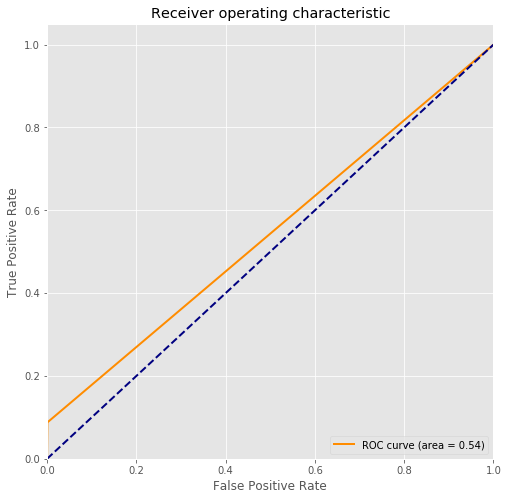

In [83]:
fpr, tpr, _ = roc_curve(ytest, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'Variable Importance from Random Forest Model')

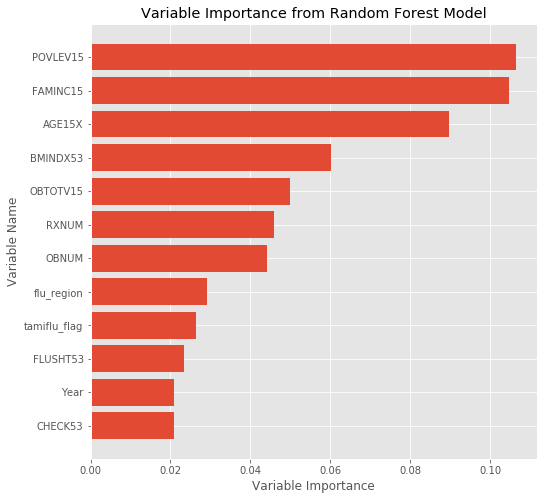

In [84]:
var_importance = pd.DataFrame(xtrain.columns)
var_importance['Importance'] = randomforest.feature_importances_
var_import = dict(zip(var_importance.sort_values(by=['Importance'], ascending=False)[0], 
                      var_importance.sort_values(by=['Importance'], ascending=False).Importance))
values = list(var_import.values())[0:12]
labels = list(var_import.keys())[0:12]

plt.figure(figsize=(8,8))
plt.barh(range(12),values[::-1])
plt.yticks(range(12),labels[::-1])
plt.ylabel('Variable Name')
plt.xlabel('Variable Importance')
plt.title('Variable Importance from Random Forest Model')


In [85]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

gradientboosting = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=5, )
gradientboosting.fit(xtrain, ytrain)

predictions2 = gradientboosting.predict(xtest)
print('Test Accuracy Rate: ',round(accuracy_score(ytest, predictions2),3))
confusion_matrix(ytest, predictions2)

Test Accuracy Rate:  0.935


array([[33084,   648],
       [ 1642,    53]], dtype=int64)

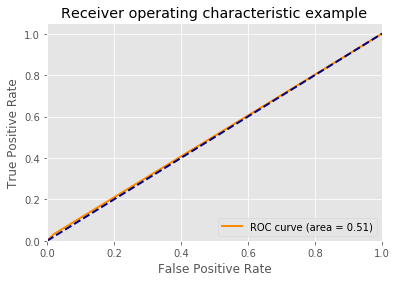

In [86]:
fpr, tpr, _ = roc_curve(ytest, predictions2)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [87]:
var_importance2 = pd.DataFrame(xtrain.columns)
var_importance2['Importance'] = gradientboosting.feature_importances_
var_importance2.sort_values(by='Importance', ascending=False).head(10)

,0,Importance
73,tamiflu_flag,0.814297
0,AGE15X,0.066392
47,PREGNT53_1,0.035423
68,IPNUM,0.020402
4,FAMINC15,0.017466
75,flu_region,0.013345
57,INSURC15_1,0.007939
65,POVLEV15,0.004581
3,FOODMN15,0.003259
72,RXNUM,0.002400


### Try upsampling - double the number of flu cases and run same models

In [88]:
from sklearn.utils import resample

majority = training[training.flu_flag==0]
minority = training[training.flu_flag==1]

# sample with replacement to be 10% of majority class
flu_upsampled = resample(minority, replace=True,n_samples=20000,random_state=123)

flu_upsampled_training = pd.concat([majority, flu_upsampled])

flu_upsampled_training.flu_flag.value_counts()

0    102661
1     20000
Name: flu_flag, dtype: int64

In [89]:
upsampled_ytrain = flu_upsampled_training.flu_flag
upsampled_xtrain = flu_upsampled_training.drop(columns=['flu_flag','DUPERSID'])

upsampled_random_forest = RandomForestClassifier(n_estimators=200,criterion='entropy',n_jobs=-1)
upsampled_random_forest.fit(upsampled_xtrain, upsampled_ytrain)
upsampled_predictions = upsampled_random_forest.predict(xtest)

In [90]:
print('Test Accuracy Rate: ',round(accuracy_score(ytest, upsampled_predictions),3))
confusion_matrix(ytest, upsampled_predictions)

Test Accuracy Rate:  0.956


array([[33707,    25],
       [ 1549,   146]], dtype=int64)

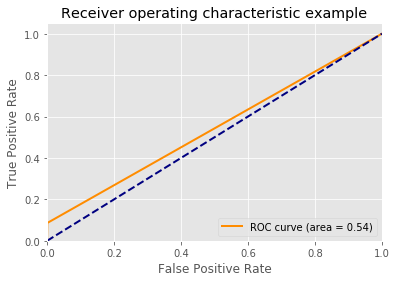

In [91]:
fpr, tpr, _ = roc_curve(ytest, upsampled_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [92]:
upsampled_gradientboosting = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=5, )
upsampled_gradientboosting.fit(upsampled_xtrain, upsampled_ytrain)

upsampled_predictions2 = upsampled_gradientboosting.predict(xtest)
print('Test Accuracy Rate: ',round(accuracy_score(ytest, upsampled_predictions2),3))
confusion_matrix(ytest, upsampled_predictions2)

Test Accuracy Rate:  0.92


array([[32392,  1340],
       [ 1485,   210]], dtype=int64)

In [93]:
var_importance_upsample = pd.DataFrame(xtrain.columns)
var_importance_upsample['Importance'] = upsampled_gradientboosting.feature_importances_
var_importance_upsample.sort_values(by='Importance', ascending=False).head(10)

,0,Importance
65,POVLEV15,0.200738
4,FAMINC15,0.181848
0,AGE15X,0.072261
66,BMINDX53,0.065129
72,RXNUM,0.037325
70,OBNUM,0.037135
11,OBTOTV15,0.035703
75,flu_region,0.034833
5,SSECP15X,0.018407
6,CHECK53,0.017741


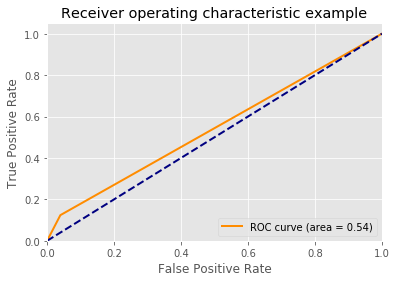

In [94]:
fpr, tpr, _ = roc_curve(ytest, upsampled_predictions2)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Try Penalized SVMs... or not because it takes so long

In [95]:
# #no upsampling

# from sklearn.svm import SVC

# svm = SVC(kernel='linear', class_weight='balanced',probability=True)

# svm.fit(xtrain, ytrain)
# svm_predict = svm.predict(xtest)
# print('Test Accuracy Rate: ',round(accuracy_score(ytest, svm_predict),3))
# confusion_matrix(ytest, svm_predict)

# fpr, tpr, _ = roc_curve(ytest, svm_predict)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

### Use stochastic gradient descent instead because its faster...

C:\Users\spleahy\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Test Accuracy Rate:  0.952


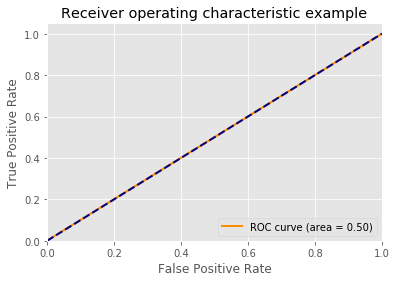

In [96]:
#using stochastic gradient descent
from sklearn.linear_model import SGDClassifier

sgd_svm = SGDClassifier(penalty='elasticnet', class_weight='balanced')

sgd_svm.fit(xtrain, ytrain)
sgd_predict = sgd_svm.predict(xtest)

print('Test Accuracy Rate: ',round(accuracy_score(ytest, sgd_predict),3))
confusion_matrix(ytest, sgd_predict)

fpr, tpr, _ = roc_curve(ytest, sgd_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# See other notebook for further model building and predictions